About Project:
This is Entity Extraction from the semi-structured data (form type). The data was provided in pdf and jpegs format, which was processed through the OCR then the manual part of labelling was carried out by team. Once the baselines had been set using Google NLP product, the custom models were deployed to solve the problem.

This notebook is part of 4 approaches. This notebook implements the Entity Extarction by exploiting the features of token. The final assessment is done by comparing the each token labels and if it 'exactly' matches the actual label then only the prediction is considered correct ( this was done to benchmark it with Google AUTO ML part ). Though the model structure for each entity is same, but they werre trained for each separately for each entity.

In [ ]:
! pip install tensorflow_addons

     |████████████████████████████████| 1.1 MB 9.0 MB/s 


In [ ]:
# installing necessary notebooks
import pandas as pd
import spacy
import numpy as np
import json
import tensorflow as tf
import operator
from tensorflow.keras import backend as be
from tensorflow.keras import layers
from tensorflow.keras.layers import LSTM, Input
from tensorflow.keras.models import Model
from keras.constraints import maxnorm
from tensorflow_addons.optimizers import RectifiedAdam
from tensorflow_addons.metrics import F1Score
from tensorflow.keras.losses import binary_crossentropy

from tensorflow.keras.optimizers import Adam,Adadelta,RMSprop
from tensorflow.keras  import losses
from tensorflow.keras import backend as be
from keras.utils.vis_utils import plot_model
from numpy.random import seed
seed(7)
tf.compat.v1.set_random_seed(7)
import pickle

In [ ]:
# Lets mount the Google Drive and acccess the data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The code for reading and extracting the information from jsonl file.

##### EXTRACTION OF LABELS START OFFSET AND END OFFSET VALUES and TOKENS

In [ ]:
# as the the file type is jsonl, each invoice is represented by hierarchial json object, therefore
# we need to fetch each invoice in hierarchial manner
# further this will access the folder from where to read the fiels, so please change the path 
# as per your specifications.
documents = []

# each invoice belogs to either train, validation, test set
category = []

# with the json object of each invoice we also have another json object with key (label), value (string) pair
# each annotation(label) has been given one initial 'null' value as there cannot be empty dictionary with keys.
placeholder = {'Date':['null'], 'Address': ['null'], 'Name':['null'], 'Amount':['null']}


# this is similar to placeholder but will read the tokens provided by OCR for each invoice.
tokens = {'sentTokens':['null'], 'sentToken_startOffset':['null'], 'sentToken_endOffset':['null'],'boundingPoly':['null']}


# this reads the csvfile which gives list of all json files
list_ = pd.read_csv('/content/drive/MyDrive/ING/Filtered_data/text_extraction.csv',usecols=[0,2], names=['Type', 'Filename'], header=None)
for type_, file_name in list_.itertuples(index=False):

    # read the jsonfile
    with open('/content/drive/MyDrive/ING/Filtered_data/{}'.format(file_name), 'r', encoding="utf8") as json_file:
        json_list = list(json_file)

    # each invoice is encapsulated in one dictionary with many key-value pairs
    for json_str in json_list:
        result = json.loads(json_str)


        #-----------------READING THE RAW TEXT AND INVOICE TYPE-------------------------------------------
        # extracting the raw text provided by OCR 
        documents.append(result['document']['documentText']['content'])

        # extracting the invoice type (train/validation/test) 
        category.append(type_)

        #------------------EXTRACTING OFFSET VALUES FOR LABELS------------------------------------------
        # As not all invoices has all the 4 annotations we need to keep track of same
        truth_table = {'Date': False, 'Address': False, 'Name': False, 'Amount':False}

        # extracting the annotations and appending them to the placeholder
        for i in range(len(result['annotations'])):
                placeholder[result['annotations'][i]['displayName']].append(result['annotations'][i]['textExtraction']['textSegment'])
                truth_table[result['annotations'][i]['displayName']] = True
        
        # if any annotation not available for invoice them append empty value for same 
        for key, value in truth_table.items():
            if value == False:
                placeholder[key].append({})

        #--------------------------------EXTRACTING TOKENS GIVEN BY OCR for EACH INVOICE and its bounding Polygon--------------------------
        temp = {'tokensOfinvoice':[],'polygons':[]}
        start_off = []
        end_off = []

        # extracting the raw text provided by OCR 
        for i in range(len(result['document']['layout'])):
            temp['tokensOfinvoice'].append(result['document']['layout'][i]['textSegment']['content'])
            temp['polygons'].append(result['document']['layout'][i]['boundingPoly']['normalizedVertices'])
            if 'startOffset' in result['document']['layout'][i]['textSegment']:
                start_off.append(int(result['document']['layout'][i]['textSegment']['startOffset']))
            else:
                start_off.append(0)
            
            if 'endOffset' in result['document']['layout'][i]['textSegment']:
                end_off.append(int(result['document']['layout'][i]['textSegment']['endOffset']))
            else: 
                end_off.append(-1)

        tokens['sentTokens'].append(temp['tokensOfinvoice'])
        tokens['boundingPoly'].append(temp['polygons'])
        tokens['sentToken_startOffset'].append(start_off)
        tokens['sentToken_endOffset'].append(end_off)


# getting the list of all annotations offset ,tokens and respective bounding polygons ( removing first null entry )
placeholder['Date'] = placeholder['Date'][1:]
placeholder['Address']= placeholder['Address'][1:]
placeholder['Name'] = placeholder['Name'][1:]
placeholder['Amount'] = placeholder['Amount'][1:]

placeholder['sentTokens'] = tokens['sentTokens'][1:]
placeholder['sentToken_startOffset'] = tokens['sentToken_startOffset'][1:]
placeholder['sentToken_endOffset'] = tokens['sentToken_endOffset'][1:]
placeholder['boundingPoly'] = tokens['boundingPoly'][1:]

# appending the raw text and type of invoice
placeholder['text'] = documents
placeholder['dataType'] = category


# checking for count of all annotations and documents
print(placeholder.keys())
print(len(placeholder['Amount']))
print(len(placeholder['Date']))
print(len(placeholder['Address']))
print(len(placeholder['Name']))
print(len(placeholder['text']))
print(len(placeholder['dataType']))

data = pd.DataFrame.from_dict(placeholder)

# Remember we have dictionary containing the start and end offset, we can extractt them 
# separately too, if required.
#--------------------------------------------------------------------------
for keys in ['Date', 'Address', 'Name', 'Amount']:
    # sometimes startoffset might not be present if annotation start from first index of raw text
    data['{}_start'.format(keys)] = data[keys].apply(lambda x: int(x['startOffset']) if 'startOffset' in x.keys()
                        else ( 0 if 'endOffset' in x.keys() else None ))

    # similarly as above endoffset might not be present if the annotations end is last index of raw text                 
for keys in ['Date', 'Address', 'Name', 'Amount']:   
    data['{}_end'.format(keys)] = data[keys].apply(lambda x: int(x['endOffset']) if 'endOffset' in x.keys()
                        else ( -1 if 'startOffset' in x.keys() else None))

data = data.drop(['Date', 'Address', 'Name', 'Amount'], axis = 1)

dict_keys(['Date', 'Address', 'Name', 'Amount', 'sentTokens', 'sentToken_startOffset', 'sentToken_endOffset', 'boundingPoly', 'text', 'dataType'])
949
949
949
949
949
949


Lets contruct the target for the models, the OCR gives the startoffset and endoffset for each label, however this is at a character level. To make the encoding for each label at token level, we will use simple logic if the startOffset or endoffset of token lies within the bounds of actual annotation (start and end offset) then its part of annotation else not. This approach has limitation, because if the actual label is sub-part of token then this will can make model to learn wrong things, however given we are using tokens given by OCR this cant be avoided.This is one limitation of using the output of OCR. This same cause is also the reason for the AutoML bad performance, because any model will work on token level, however if the labelling is done by taking the sub-span within token then model is not able to take that into factor.

In [ ]:

# placeholder to keep the target of each label
import math
placeholder = {'Date':['null'], 'Address': ['null'], 'Name':['null'], 'Amount':['null']}
for i,j in placeholder.items():
    for a,b,c,d in zip(data['sentToken_startOffset'],data['sentToken_endOffset'],data['{}_start'.format(i)], data['{}_end'.format(i)]):

        if not math.isnan(c):
            
            start_left = np.array(a) >=c
            start_right = np.array(a) <=d
            start_truth_table = start_left == start_right
            
            end_left = np.array(b)  >= c
            end_right = np.array(b) <=d
            end_truth_table = end_left == end_right
            truth_table = start_truth_table + end_truth_table 

            placeholder['{}'.format(i)].append(truth_table.astype(int))
        else:
            placeholder['{}'.format(i)].append(list(np.zeros(len(a)).astype(int)))

# removing the first null entry.
placeholder['dateTarget'] = placeholder['Date'][1:]
placeholder['addressTarget']= placeholder['Address'][1:]
placeholder['nameTarget'] = placeholder['Name'][1:]
placeholder['amountTarget'] = placeholder['Amount'][1:]

del placeholder['Address'], placeholder['Amount'], placeholder['Date'], placeholder['Name']
# creating final dataframe 
y = pd.DataFrame.from_dict(placeholder)
data = pd.concat([data,y], axis =1)

In [ ]:
# If any token is present in label, then the the max value in the list for that sentence for that label will be 1, 
# hence if eveything is fine then we shoud see same numbers for all labels. However as highlighted due to slicing of token in case of amount, 
# it is have mis match. 
# Ex: if the token is RM170.00, now in labelling the actual value of amount is just 170.00, but since this value is sub-span of this whole token, 
# the encoding cannnot be done eeasily, therefore we to take care of such cases we take the whole token rather than just the sub-span.

print('number of Date labels', sum([max(x) for x in data.dateTarget]))
print('number of Name labels', sum([max(x) for x in data.nameTarget]))
print('number of Address labels', sum([max(x) for x in data.addressTarget]))
print('number of Amount labels', sum([max(x) for x in data.amountTarget]))

number of Date labels 946
number of Name labels 947
number of Address labels 949
number of Amount labels 944


Before we proceed lets invistigate if everything is okay in terms of data frame creation or not. We will do this by extracting the token from annotations encoding for each label and comparing with the actuals.

In [ ]:
## get the tokens set which form part of each label.

temp = [np.array(token)[np.array(mask == 1)] for (token, mask) in zip(data.sentTokens, data.dateTarget) ]
data['dateTokens'] = temp

temp = [np.array(token)[np.array(mask == 1)] for (token, mask) in zip(data.sentTokens, data.nameTarget) ]
data['nameTokens'] = temp

temp = [np.array(token)[np.array(mask == 1)] for (token, mask) in zip(data.sentTokens, data.addressTarget) ]
data['addressTokens'] = temp

temp = [np.array(token)[np.array(mask == 1)] for (token, mask) in zip(data.sentTokens, data.amountTarget) ]
data['amountTokens'] = temp


In [ ]:
# lets check the whole dataframe
data

,sentTokens,sentToken_startOffset,sentToken_endOffset,boundingPoly,text,dataType,Date_start,Address_start,Name_start,Amount_start,Date_end,Address_end,Name_end,Amount_end,dateTarget,addressTarget,nameTarget,amountTarget,dateTokens,nameTokens,addressTokens,amountTokens
0,"[RESTAURANT, SIN, DU, K3-113, ,, JL, IBRAHIM, ...","[0, 11, 15, 18, 24, 26, 29, 37, 44, 50, 56, 62...","[10, 14, 17, 24, 25, 28, 36, 43, 49, 55, 61, 6...","[[{'x': 0.33425927, 'y': 0.25343812}, {'x': 0....","RESTAURANT SIN DU\nK3-113, JL IBRAHIM SULTAN\n...",TRAIN,97.0,18,0.0,183.0,107.0,67,17.0,190.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, ...","[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[09/03/2018],"[RESTAURANT, SIN, DU]","[K3-113, ,, JL, IBRAHIM, SULTAN, 80300, JOHOR,...","[170., 00]"
1,"[อ, ว, ), BECON, STATIONER, Becon, Enterprise,...","[0, 1, 2, 4, 10, 20, 26, 37, 41, 45, 46, 51, 5...","[1, 2, 3, 9, 19, 25, 36, 40, 44, 46, 51, 52, 5...","[[{'x': 0.8927039, 'y': 0.058606368}, {'x': 0....",อว)\nBECON STATIONER\nBecon Enterprise Sdn Bhd...,TRAIN,234.0,78,20.0,710.0,244.0,134,44.0,716.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[13-11-2017],"[Becon, Enterprise, Sdn, Bhd]","[No.41G, ,, Jln, SS21, /, 60, ,, Damansara, Ut...",[270.10]
2,"[GARDENIA, BAKERIES, (, KL, ), SDN, BHD, (, 13...","[0, 9, 18, 19, 21, 23, 27, 31, 32, 39, 43, 44,...","[8, 17, 19, 21, 22, 26, 30, 32, 38, 42, 44, 45...","[[{'x': 0.050324675, 'y': 0.07731093}, {'x': 0...","GARDENIA BAKERIES (KL) SDN BHD (139386\nLot 3,...",TRAIN,212.0,39,0.0,654.0,222.0,91,30.0,658.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[16/09/2017],"[GARDENIA, BAKERIES, (, KL, ), SDN, BHD]","[Lot, 3, ,, Jalan, Pelabur, 23.1, ,, 40300, Sh...",[3.21]
3,"[MYDIN, TRI, SHAAS, SDN, BHD, (, 728515, -, M,...","[0, 6, 10, 16, 20, 24, 25, 31, 32, 33, 35, 41,...","[5, 9, 15, 19, 23, 25, 31, 32, 33, 34, 40, 45,...","[[{'x': 0.24736226, 'y': 0.04020497}, {'x': 0....",MYDIN\nTRI SHAAS SDN BHD (728515-M)\nMYDIN MAR...,TRAIN,245.0,55,6.0,736.0,254.0,128,23.0,741.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[4/02/2017],"[TRI, SHAAS, SDN, BHD]","[4-20, ,, Jalan, Ria, 25/62, Taman, Sri, Muda,...",[85.10]
4,"[99, SPEED, MART, S, /, B, (, 519537, -, X, ),...","[0, 3, 9, 14, 15, 16, 18, 19, 25, 26, 27, 29, ...","[2, 8, 13, 15, 16, 17, 19, 25, 26, 27, 28, 32,...","[[{'x': 0.187251, 'y': 0.21455939}, {'x': 0.22...","99 SPEED MART S/B (519537-X)\nLOT P.T. 2811, J...",TRAIN,187.0,29,0.0,261.0,195.0,93,17.0,266.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[19-03-18],"[99, SPEED, MART, S, /, B]","[LOT, P.T., 2811, ,, JALAN, ANGSA, ,, TAMAN, B...",[11.40]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
944,"[SANYU, STATIONERY, SHOP, NO, ., 316, &, 33G, ...","[0, 6, 17, 22, 24, 26, 29, 30, 33, 35, 41, 47,...","[5, 16, 21, 24, 25, 29, 30, 33, 34, 40, 46, 52...","[[{'x': 0.086677365, 'y': 0.08934481}, {'x': 0...","SANYU STATIONERY SHOP\nNO. 316&33G, JALAN SETI...",TEST,492.0,22,0.0,386.0,502.0,78,21.0,390.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[02/12/2017],"[SANYU, STATIONE

This is just for demonstration purpose

In [ ]:
## Lets read the actual text which form part of each label
# placeholder for annotations text
placeholder = {'Date':['null'], 'Address': ['null'], 'Name':['null'], 'Amount':['null']}

for keys in ['Date', 'Address', 'Name', 'Amount']: 
    # read annotation_start, annotation_end and text from data
    for a,b,c in data[['{}_start'.format(keys), '{}_end'.format(keys), 'text']].itertuples(index=False):
        # extracting the text
        if not np.isnan(a) and  not np.isnan(b):
            placeholder[keys].append(c[int(a):int(b)])
        # if annotation not present then append None
        else:
            placeholder[keys].append(None)

placeholder['dateTextactual'] = placeholder['Date'][1:]
placeholder['addressTextactual']= placeholder['Address'][1:]
placeholder['nameTextactual'] = placeholder['Name'][1:]
placeholder['amountTextactual'] = placeholder['Amount'][1:]

del placeholder['Address'], placeholder['Amount'], placeholder['Date'], placeholder['Name']

y = pd.DataFrame.from_dict(placeholder)

###-------Lets construct the each annotations from tokens and targetencoding
temp = [' '.join([str(tokens) for tokens in list_])      for list_ in data.dateTokens]
y['dateFromTokens'] = temp

temp = [' '.join([str(tokens) for tokens in list_])      for list_ in data.nameTokens]
y['nameFromTokens'] = temp

temp = [' '.join([str(tokens) for tokens in list_])      for list_ in data.addressTokens]
y['addressFromTokens'] = temp

temp = [' '.join([str(tokens) for tokens in list_])      for list_ in data.amountTokens]
y['amountFromTokens'] = temp

In [ ]:
# just for demo..purpose
y

,dateTextactual,addressTextactual,nameTextactual,amountTextactual,dateFromTokens,nameFromTokens,addressFromTokens,amountFromTokens
0,09/03/2018,"K3-113, JL IBRAHIM SULTAN\n80300 JOHOR BAHRU\n...",RESTAURANT SIN DU,170. 00,09/03/2018,RESTAURANT SIN DU,"K3-113 , JL IBRAHIM SULTAN 80300 JOHOR BAHRU J...",170. 00
1,13-11-2017,"No.41G, Jln SS21/60, Damansara\nUtama, 47400 P...",Becon Enterprise Sdn Bhd,270.10,13-11-2017,Becon Enterprise Sdn Bhd,"No.41G , Jln SS21 / 60 , Damansara Utama , 474...",270.10
2,16/09/2017,"Lot 3, Jalan Pelabur 23.1,\n40300 Shah Alam, S...",GARDENIA BAKERIES (KL) SDN BHD,3.21,16/09/2017,GARDENIA BAKERIES ( KL ) SDN BHD,"Lot 3 , Jalan Pelabur 23.1 , 40300 Shah Alam ,...",3.21
3,4/02/2017,"4-20, Jalan Ria 25/62 Taman Sri Muda\nSeksyen ...",TRI SHAAS SDN BHD,85.10,4/02/2017,TRI SHAAS SDN BHD,"4-20 , Jalan Ria 25/62 Taman Sri Muda Seksyen ...",85.10
4,19-03-18,"LOT P.T. 2811, JALAN ANGSA,\nTAMAN BERKELEY\n4...",99 SPEED MART S/B,11.40,19-03-18,99 SPEED MART S / B,"LOT P.T. 2811 , JALAN ANGSA , TAMAN BERKELEY 4...",11.40
...,...,...,...,...,...,...,...,...
944,02/12/2017,"NO. 316&33G, JALAN SETIA INDAH X ,U13/X\n40170...",SANYU STATIONERY SHOP,8.70,02/12/2017,SANYU STATIONERY SHOP,"NO . 316 & 33G , JALAN SETIA INDAH X , U13 / X...",8.70
945,19-03-2018,"No.2, Jalan Temenggung 19/9,\nSeksyen 9, Banda...",RESTORAN WAN SHENG,9.10,19-03-2018,RESTORAN WAN SHENG,"No.2 , Jalan Temenggung 19/9 , Seksyen 9 , Ban...",9.10
946,1 MAR 2018,"LOT 1951-A & 1851-8, JALAIKOD 6,\nKAWASAN PERI...",MR. D.I.Y W) SDN BHD,37.10,1 MAR 2018,MR . D.I.Y W ) SDN BHD,"LOT 1951 - A & 1851-8 , JALAIKOD 6 , KAWASAN P...",37.10
947,05-Jan-2017,"NO. 36G JALAN BULAN BM U5/BM,\nBANDAR PINGGIRA...",S&Y STATIONERY,72.00,05 - Jan - 2017,S & Y STATIONERY,"NO . 36G JALAN BULAN BM U5 / BM , BANDAR PINGG...",72.00


Lets start building the model now. We will start with feature extraction. For this we will use the spacy to give features values for each token. 

> 
*   Feature1: index of token in the invoice
*   Feature2: POS of token, usually this is used in proper sentences only, however we will try to see if even getting POS for single token like whether it is (NOUN, PNOUN  etc helps or not)
*   Feature3: Shape type of token
*   Feature4: Whether Token is like Num or not ( its different from is-alpha Ex: 01-11189 will have like_Num =  True and is_alpha = False, but the token 21:15 will have like_Num = False and is_alpha = False, as the other is likely representing time and is not purely a Number)
*   Feature5: Is token alphanumeric or not

Lets have a look what kind of values we get one invoice

In [ ]:
# creating nlp object for getting the features of each token.
nlp = spacy.load("en_core_web_sm")

In [ ]:
# demonstration of features
temp = []
for word in data.sentTokens[0]:
  token = nlp(word)
  temp.append([word,token[0].pos_, token[0].shape_ , token[0].like_num, token[0].is_alpha])

df = pd.DataFrame(temp, columns=['Word','POS','SHAPE','LIKE_NUM','IS_ALPHANUMERIC'])
df

,Word,POS,SHAPE,LIKE_NUM,IS_ALPHANUMERIC
0,RESTAURANT,NOUN,XXXX,False,True
1,SIN,PROPN,XXX,False,True
2,DU,PROPN,XX,False,True
3,K3-113,PROPN,Xd,False,False
4,",",PUNCT,",",False,False
5,JL,PROPN,XX,False,True
6,IBRAHIM,PROPN,XXXX,False,True
7,SULTAN,PROPN,XXXX,False,True
8,80300,NUM,dddd,True,False
9,JOHOR,PROPN,XXXX,False,True


In [ ]:

# function to take the list of tokens for each invoice and return the features for each token

def sent2features(sent,posdict,shapedict):
    countOfPos = len(posdict)
    countOfShape = len(shapedict)
    
    idx = 0
    temp = []
    for word in sent:        
        token = nlp(word)
        if token[0].pos_ not in posdict:
            posdict[token[0].pos_] = countOfPos
            countOfPos += 1
        if token[0].shape_ not in shapedict:
            shapedict[token[0].shape_] = countOfShape
            countOfShape += 1

        # we need the ids of each feature rather than feature value 
        temp.append([idx, posdict[token[0].pos_], shapedict[token[0].shape_], token[0].like_num, token[0].is_alpha]) 
        idx +=1

    return np.array(temp), posdict, shapedict

# function to iterate over the all invoice, this will call sent2features internally
def prep_features(sents,posdict ={},shapedict={}):
    sent_features = []
    for sent in sents:
        temp, posdict, shapedict = sent2features(sent, posdict, shapedict)
    
        temp = np.transpose(temp)
        # we need each entry of same size, thereofre doing padding
        temp = tf.keras.preprocessing.sequence.pad_sequences(temp, padding='post', maxlen= max_len, value = -1)
        temp = np.transpose(temp)
        sent_features.append(temp)

    return np.array(sent_features), posdict,shapedict


# this is just some tokenizing technique using keras and create the library of tokens...
# lets build custom tokenizer adapted for this corpus

def tokenize(lang, num_words = None):
    # lang = list of sentences in a language
    # lets select the default config and basic Tokenizer from keras
    
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', oov_token='<OOV>', num_words= num_words)

    # this step is necessary to allow the tokenzier to build its words id for the corpus 
    # from the lang = list of sentences
    lang_tokenizer.fit_on_texts(lang)

    ## tf.keras.preprocessing.text.Tokenizer.texts_to_sequences converts string (w1, w2, w3, ......, wn) 
    ## to a list of correspoding integer ids of words (id_w1, id_w2, id_w3, ...., id_wn)
    tensor = lang_tokenizer.texts_to_sequences(lang) 

    ## tf.keras.preprocessing.sequence.pad_sequences takes argument a list of integer id sequences 
    ## and pads the sequences to match the longest sequences in the given input
    # this will make all sentences of same length
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post', value = 0)

    return tensor, lang_tokenizer

We will create two array one as features of each token described above and other for the list of token ( the token id will be provided by tokenizer defined above)

In [ ]:
posdict = {}
shapedict = {}

# getting max length of sequence of tokens for invoices
# we need this variable for padding
max_len = max([len(x) for x in data.sentTokens])
print("max length is {}".format(max_len))

# we will be dropping the data where any label is missing, this will be done in training
type_data = ['TRAIN', 'VALIDATION', 'TEST']
d_train = data[data.dataType == 'TRAIN']
d_train = d_train.dropna(axis = 0, subset= ['Date_start','Name_start','Address_start','Amount_start','Date_end','Address_end','Name_end','Amount_end'])

X_train_feat, posdict, shapedict = prep_features(d_train.sentTokens)
X_valid_feat, posdict, shapedict = prep_features(data[data.dataType == 'VALIDATION'].sentTokens ,posdict,shapedict )
X_test_feat,posdict, shapedict = prep_features(data[data.dataType == 'TEST'].sentTokens , posdict, shapedict)


max length is 317


In [ ]:
# getting token ids for each token and padding each invoice
# Further we split the data (train, validation and test)

# splitting the data
X_train, tokenizer_ = tokenize(d_train.sentTokens)
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=max_len, padding='post', value = 0)

X_valid = tokenizer_.texts_to_sequences(data[data.dataType == 'VALIDATION'].sentTokens)
X_valid = tf.keras.preprocessing.sequence.pad_sequences(X_valid, maxlen=max_len, padding='post', value = 0)

X_test = tokenizer_.texts_to_sequences(data[data.dataType == 'TEST'].sentTokens)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=max_len, padding='post', value = 0)

In [ ]:
# Conv2D layers will will need the 3Dimensions apart from batch size ( fourth dimension is morelike channel)
X_train_feat= np.expand_dims(X_train_feat,-1)
X_valid_feat= np.expand_dims(X_valid_feat,-1)

In [ ]:
# lets have a look at the shapes of data
print("X_TRAIN",X_train.shape)
print("Train_features",X_train_feat.shape)
print("X_VALID",X_valid.shape)
print("Valid_features",X_valid_feat.shape)

X_TRAIN (750, 317)
Train_features (750, 317, 5, 1)
X_VALID (97, 317)
Valid_features (97, 317, 5, 1)


In [ ]:
def build_model():

  # we will create two inputs one which has sequence of just tokens and
  # other which has feature of each token (so array of features of each token)
  x1 = Input(shape=(max_len,))
  x2 = Input(shape = (max_len,X_train_feat.shape[2],1))
#----------------------------------------TOKEN LSTM -----------------------------------

  mask1 = layers.Masking(mask_value=0)(x1)
  embed = layers.Embedding(input_dim= len(tokenizer_.word_index), output_dim=128, input_length=max_len)(mask1)


#---------------------------------------------FEATURE CONVOLUTION-----------------------------

  mask2 = layers.Masking(mask_value=-1)(x2)
  conv1 = layers.Conv2D(filters = 64, kernel_size= 4, strides = 1, padding= "same", activation = 'relu')(mask2)
  conv2 = layers.Conv2D(filters = 32, kernel_size= 4, strides = 1, padding= "same", activation = 'relu')(conv1)
  reshape1 = layers.Reshape((317,160), input_shape = (317,5,32))(conv2)
  # you can add more layers and make network more complex here

#----------------------------------------------Merging both---NOW BILSTM starts-------------------

  merge = layers.concatenate([embed,reshape1])
  drop1 = layers.Dropout(0.5)(merge)

  lstm1 = layers.LSTM(units= 200, return_sequences= True, dropout= 0.4)(drop1)
  bilstm1 = layers.Bidirectional(LSTM(units= 200, return_sequences= True, dropout = 0.2))(lstm1)
  bilstm2 = layers.Bidirectional(LSTM(units= 100, return_sequences= True))(bilstm1)
  norm1 = layers.BatchNormalization(axis = -1)(bilstm2)
  # you can add more layers and make model more complex.
# ------------------------------------------------------------------------------------

  # KEEP THIS INTACT
  predictions = layers.TimeDistributed(layers.Dense(1, activation='sigmoid'))(norm1)
  model = Model(inputs = ([x1,x2]), outputs = predictions)

  print(model.summary())

  return model


In [ ]:
# function to plot the loss, precision and recall, 
# caution code block has lines to save the files to drive.
def display_history(history,name ="None"):

    import seaborn as sns
    import matplotlib.pyplot as plt
    import pandas as pd
    import numpy as np                                        
    # """Summarize history for accuracy and loss.

    sns.set_palette("pastel")
    sns.set(style="darkgrid")
    path = '/content/drive/MyDrive/ING/'

    fig, ax = plt.subplots(figsize=(10,6),sharey='row')
    title = "Loss_for_{}".format(name)
    sns.lineplot(data=history.history['loss'], ax = ax)
    sns.lineplot(data=history.history['val_loss'], ax = ax)
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.title(title)
    fig.savefig(path + title + 'CONV2D.png')

    fig, ax = plt.subplots(figsize=(10,6),sharey='row')
    title = "Precision_for_{}".format(name)
    sns.lineplot(data=history.history['precision'], ax = ax)
    sns.lineplot(data=history.history['val_precision'], ax = ax)
    ax.set_xlabel('epoch')
    ax.set_ylabel('precision')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.title(title)
    fig.savefig( path + title + 'CONV2D.png')

    fig, ax = plt.subplots(figsize=(10,6),sharey='row')
    title = "Recall_for_{}".format(name)
    sns.lineplot(data=history.history['recall'], ax = ax)
    sns.lineplot(data=history.history['val_recall'], ax = ax)
    ax.set_xlabel('epoch')
    ax.set_ylabel('recall')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.title(title)
    fig.savefig( path + title + 'CONV2D.png')

In [ ]:
# creating the F1 score function
# in case you load the saved model and want to train further you will need to pass this in custom object 
# if you need to get F1 score.
def f1_metric():
  def F1(y_true, y_pred):
    true_positives = be.sum(be.round(be.clip(y_true * y_pred, 0, 1)))
    possible_positives = be.sum(be.round(be.clip(y_true, 0, 1)))
    predicted_positives = be.sum(be.round(be.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + be.epsilon())
    recall = true_positives / (possible_positives + be.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+be.epsilon())
    
    return f1_val

In [ ]:
# this will take the tag = 'date'/'name'/'address'.....make the target encoding as per that and load and compile the model
def LoadandCompile(tag):
  be.clear_session()
  temp = d_train[d_train.dataType == 'TRAIN']['{}Target'.format(tag)].tolist()
  y_train = tf.keras.preprocessing.sequence.pad_sequences(temp, padding='post', maxlen= max_len,dtype='int32', value = 0)
  y_train = np.array(y_train)

  temp = data[data.dataType == 'VALIDATION']['{}Target'.format(tag)].tolist()
  y_valid = tf.keras.preprocessing.sequence.pad_sequences(temp, padding='post', maxlen= max_len,dtype='int32', value = 0)
  y_valid = np.array(y_valid)

  # this is cutom entity so we cas use binary cross entropy.
  loss = binary_crossentropy
  optimizer=RectifiedAdam(learning_rate = 0.001, warmup_proportion = 0.2, beta_1 = 0.9, 
                                            total_steps= 2000, min_lr= 0.0008)
  model = build_model()
  model.compile(optimizer=optimizer,
                loss= loss,
                metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Precision(),tf.keras.metrics.Recall(), f1_metric])
  

  return model, y_train, y_valid  

In [ ]:
# dataframe for bookkeeping
historys = []

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 317, 5, 1)]  0           []                               
                                                                                                  
 masking_1 (Masking)            (None, 317, 5, 1)    0           ['input_2[0][0]']                
                                                                                                  
 input_1 (InputLayer)           [(None, 317)]        0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 317, 5, 64)   1088        ['masking_1[0][0]']              
                                                                                              

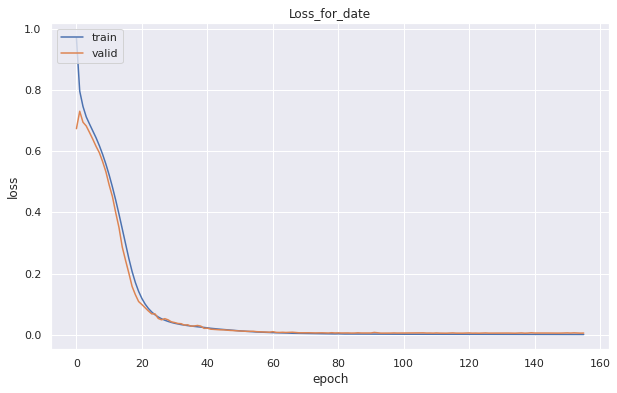

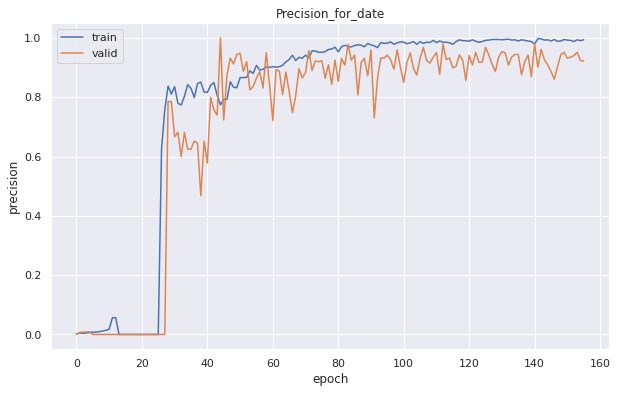

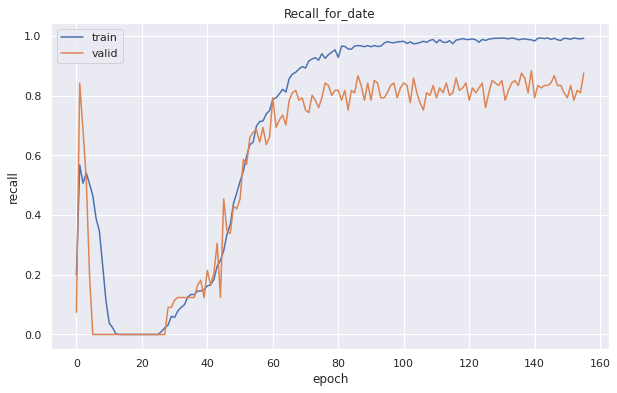

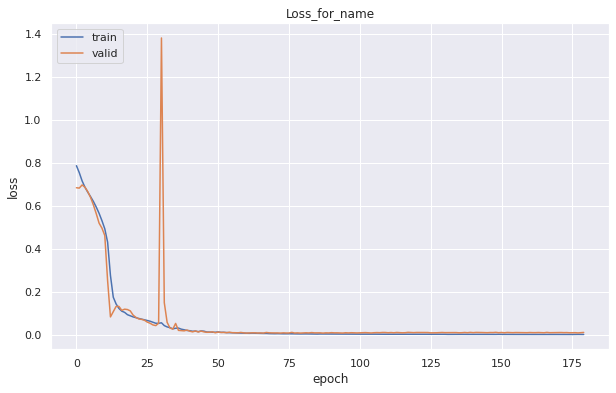

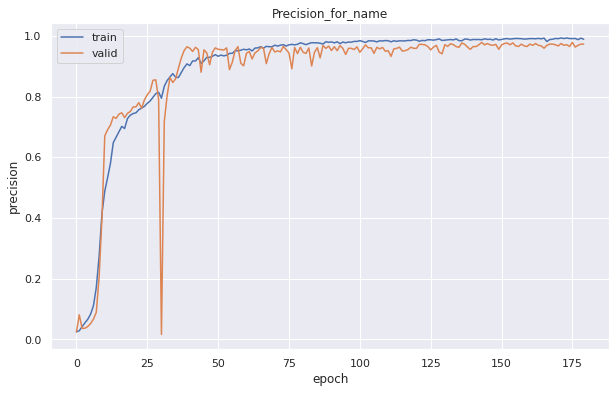

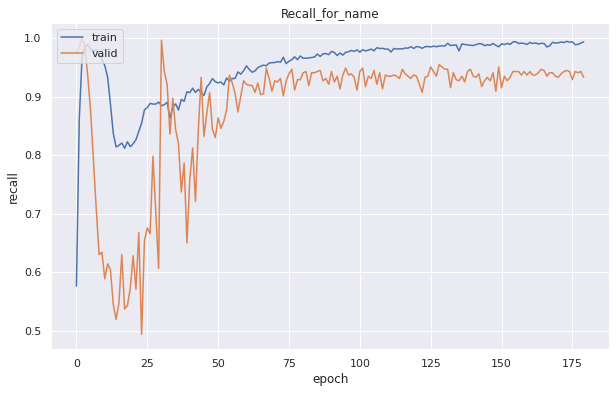

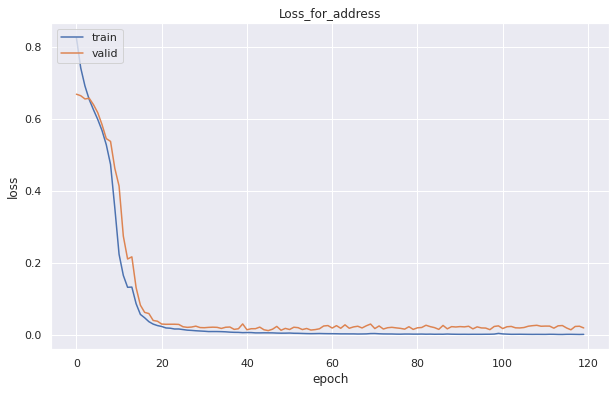

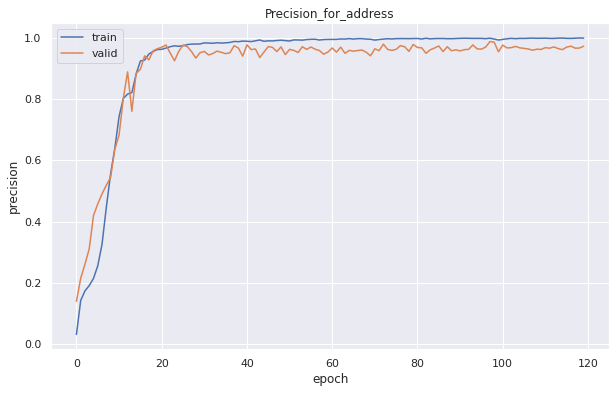

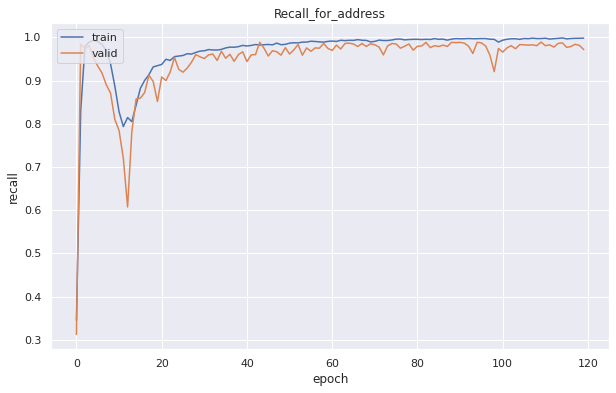

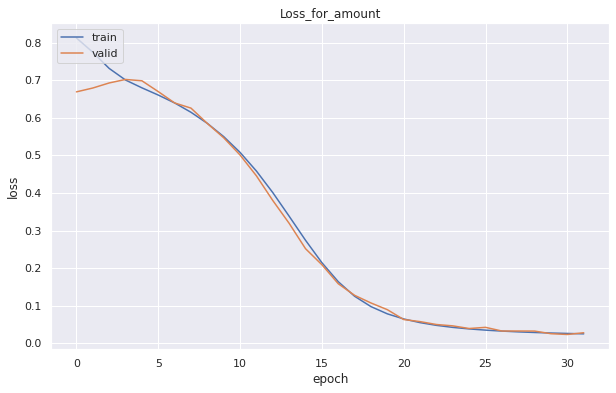

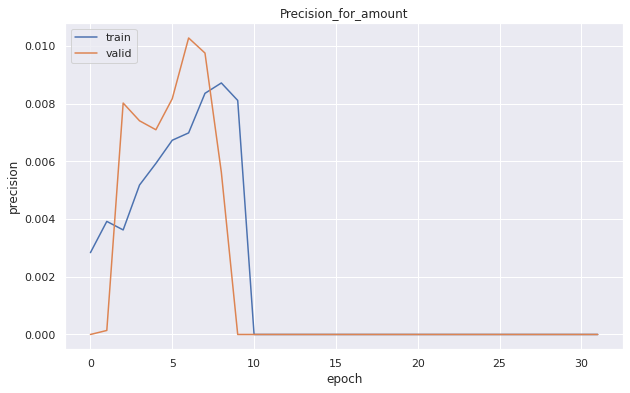

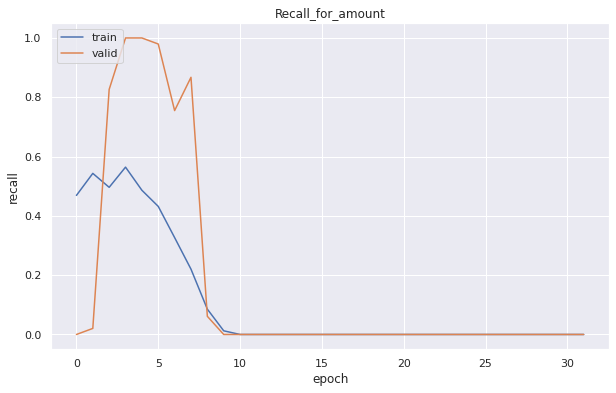

In [ ]:
# lets run the model for each annotation
annotations  = ['date', 'name', 'address', 'amount']

for i in annotations:
  be.clear_session()
  model,y_train, y_valid = LoadandCompile(i)
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_f1_metric',patience= 25,
                                                   mode='max', restore_best_weights = True)

  print("Starting training {} on with model presented above".format(i))
  history = model.fit(x=[X_train,X_train_feat], y=y_train,
                    validation_data=([X_valid,X_valid_feat], y_valid),
                    epochs=300,batch_size=32,  callbacks = [early_stopping])
  
  #   # saving the model
  model.save('/content/drive/MyDrive/ING/{}_conv2d_earlystopping.h5'.format(i))
  val_loss, val_acc, val_prec, val_recall, val_F1 = model.evaluate([X_valid,X_valid_feat],y_valid)
  historys.append([i, val_loss,val_acc,val_prec,val_recall,val_F1])
  display_history(history, name = i)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 317, 5, 1)]  0           []                               
                                                                                                  
 masking_1 (Masking)            (None, 317, 5, 1)    0           ['input_2[0][0]']                
                                                                                                  
 input_1 (InputLayer)           [(None, 317)]        0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 317, 5, 64)   1088        ['masking_1[0][0]']              
                                                                                              

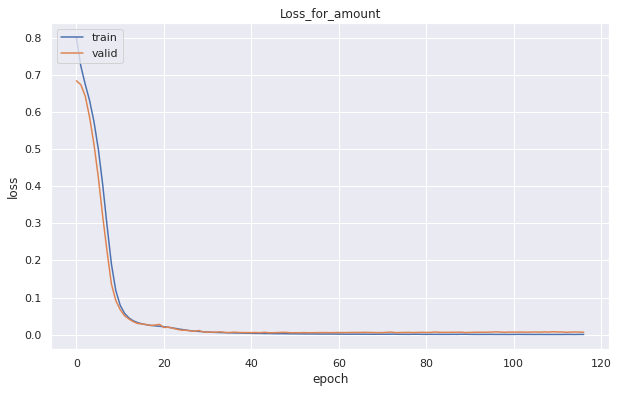

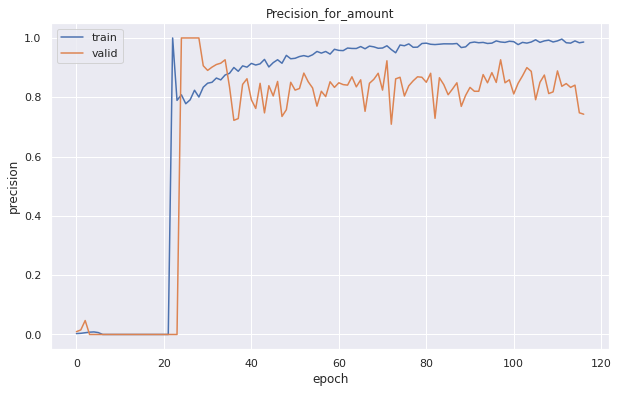

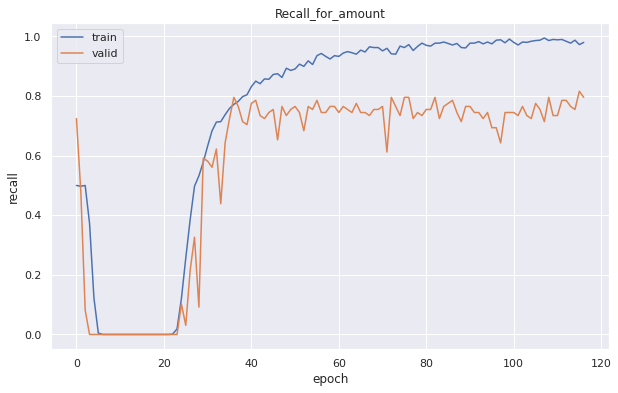

In [ ]:
# as amount behaves very differently, the patience value is changed to 40 and batch size to 16.
annotations  = ['amount']

for i in annotations:
  be.clear_session()
  model,y_train, y_valid = LoadandCompile(i)
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_f1_metric',patience= 40,
                                                   mode='max', restore_best_weights = True)

  print("Starting training {} on with model presented above".format(i))
  history = model.fit(x=[X_train,X_train_feat], y=y_train,
                    validation_data=([X_valid,X_valid_feat], y_valid),
                    epochs=300,batch_size=16,  callbacks = [early_stopping])
  
  # saving the model
  model.save('/content/drive/MyDrive/ING/{}_conv2d_earlystopping.h5'.format(i))
  val_loss, val_acc, val_prec, val_recall, val_F1 = model.evaluate([X_valid,X_valid_feat],y_valid)
  historys.append([i, val_loss,val_acc,val_prec,val_recall,val_F1])
  display_history(history, name = i)

In [ ]:
# we have got the precision and recall during the training but that is at the token level, 
# we need now to see the metrics at invoice level as thats the main problem we are solving.

def invoiceMetrices(y_pred, tag, df, threshold):
  
  df = df.reset_index()
  y_pred  = (y_pred> threshold).astype(int)
  predicted ={}
  predicted['{}'.format(tag)] = y_pred
  predicted_df = {'{}'.format(tag):['null']}

  for a,b in zip(df.sentTokens, predicted['{}'.format(tag)]):
      b = b.flatten()
      temp = [item for item in b[:len(a)]]
      predicted_df['{}'.format(tag)].append(temp)
  predicted_df['{}'.format(tag)] = predicted_df['{}'.format(tag)][1:]
  predicted_df = pd.DataFrame.from_dict(predicted_df)
  df['predicted_{}_indexs'.format(tag)] = predicted_df['{}'.format(tag)]

  TP = 0
  for a,b in zip(df['{}Target'.format(tag)],df['predicted_{}_indexs'.format(tag)]):
    count = (a == b)
    if type(count) == type(True):
      TP += 1
    elif sum(count) == len(a):
      TP += 1
  return (TP/len(y_pred))*100

In [ ]:
# book keeping
report = {'Label':[], 'Accuracy':[], 'Threshold': []}
# making testdata model ready
X_test_feat = np.expand_dims(X_test_feat,-1)
print(X_test.shape)
print(X_test_feat.shape)

(98, 317)
(98, 317, 5, 1)


In [ ]:
# getting the final metrics for each annotation
annotations  = ['amount','date','name','address']
threshold = [0.3, 0.35, 0.4,0.45, 0.5, 0.55, 0.6, 0.65]
for confidencescore in threshold:

  for tag in annotations:
    be.clear_session()
    model = tf.keras.models.load_model('/content/drive/MyDrive/ING/Conv2D/{}_conv2d_earlystopping.h5'.format(tag), compile = False)   
    # custom_objects={ 'metrics': f1_metric(y_valid, ) })
    temp = data[data.dataType == 'TEST']['{}Target'.format(tag)].tolist()
    y_test = tf.keras.preprocessing.sequence.pad_sequences(temp, padding='post', maxlen= max_len,dtype='int32', value = 0)
    y_test = np.array(y_test)
    y_pred = model.predict([X_test,X_test_feat])
    acc = invoiceMetrices(y_pred,tag,data[data.dataType == 'TEST'],confidencescore)
    report['Label'].append(tag)
    report['Accuracy'].append(acc)
    report['Threshold'].append(confidencescore)

In [ ]:
report = pd.DataFrame.from_dict(report)
report

,Label,Accuracy,Threshold
0,amount,80.612245,0.30
1,date,80.612245,0.30
2,name,76.530612,0.30
3,address,78.571429,0.30
4,amount,80.612245,0.35
5,date,80.612245,0.35
6,name,77.551020,0.35
7,address,78.571429,0.35
8,amount,79.591837,0.40
9,date,76.530612,0.40


In [ ]:
import pickle

path = '/content/drive/MyDrive/ING/'  # path to the folder in google drive where data is saved
with open(path + "X_train_feat.ob", 'wb') as a, open(path + "X_valid_feat.ob", 'wb') as b, open(path + "X_test_feat.ob", 'wb') as c:
    pickle.dump(X_train_feat, a) 
    pickle.dump(X_valid_feat, b)
    pickle.dump(X_test_feat, c)

In [ ]:
path = '/content/drive/MyDrive/ING/'  # path to the folder in google drive where data is saved
with open(path + "posdict.ob", 'wb') as a, open(path + "shapedict.ob", 'wb') as b, open(path + "data.ob", 'wb') as c:
    pickle.dump(posdict, a) 
    pickle.dump(shapedict, b)
    pickle.dump(data, c)

with open(path + "tokenizer.ob", 'wb') as a, open(path + "Conv2Dresults.ob", 'wb') as b:
  pickle.dump(tokenizer_, a)
  pickle.dump(history, b)